In [1]:
import math
import random
import itertools as it
from pathlib import Path

import mido
from pretty_midi import PrettyMIDI
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from notepredictor import NotePredictor, MIDIDataset
from notepredictor.distributions import CensoredMixtureLogistic

# data

In [2]:
data_dir = Path('/Users/victor/data/lmd_full')
files = list(data_dir.glob('**/*.mid'))

In [2]:
ds = MIDIDataset(Path('/Users/victor/data/lmd_multitrack'), 512)

In [3]:
item = ds[0]

In [4]:
%%timeit
item = ds[random.randint(0,len(ds))]

28.2 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
if (~item['mask']).any():
    print(item['mask'], item['end'])

In [4]:
item.keys()

dict_keys(['state', 'mask', 'end', 'instrument', 'pitch', 'time', 'velocity'])

In [96]:
item['instrument'].unique()

tensor([  0,   1,  25,  33,  57,  58,  67, 129])

In [103]:
time = item['time'][item['mask']]
vel = item['velocity'][item['mask']]
time.shape

torch.Size([434])

In [107]:
(vel==0).float().mean()

tensor(0.5115)

In [100]:
(time < 0).any(), time.std(), time.mean()

(tensor(False), tensor(0.1024), tensor(0.0432))

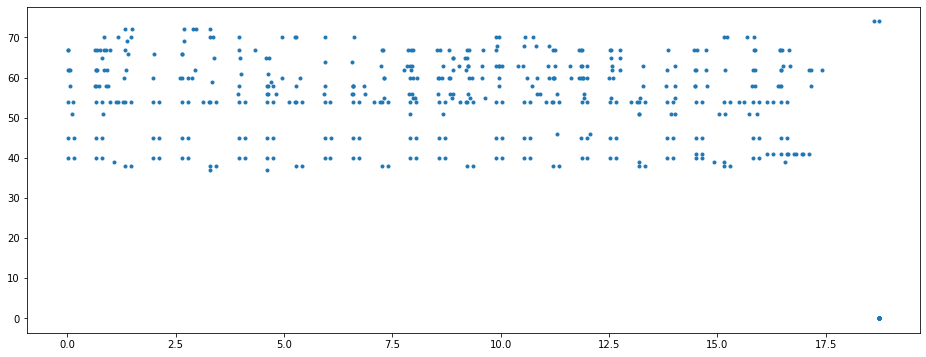

In [91]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(item['time'].cumsum(0), item['pitch'], ls='', marker='.')

In [228]:
def process(file):
    mid = PrettyMIDI(file)
    inst_events = []
    # print(mid.instruments)
    # print(mid.estimate_tempi())
    for inst in mid.instruments:
        # print(inst.program, inst.is_drum)
        inst.remove_invalid_notes()
        program = inst.program + 128*inst.is_drum
        note_ons = [(n.start, n.pitch, n.velocity, program) for n in inst.notes]
        note_offs = [(n.end, n.pitch, 0, program) for n in inst.notes]
        inst_events.extend(note_ons+note_offs)
    time, pitch, vel, prog = zip(*sorted(inst_events))
    delta = torch.tensor([0, *time]).diff(1)
    return delta, torch.tensor(pitch), torch.tensor(vel), torch.tensor(prog)

In [229]:
data = []

In [230]:
for _ in range(500):
    try:
        data.append(process(str(random.choice(files))))
    except Exception:
        pass


<AxesSubplot:>

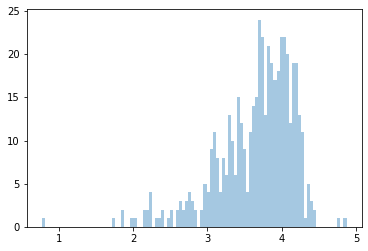

In [231]:
sns.distplot([math.log10(len(item)) for item in next(zip(*data))], bins=100, kde=False)
# plt.xscale('log')

In [232]:
delta, pitch, vel, prog = [torch.cat(items) for items in zip(*data)]
delta.shape

torch.Size([3573364])

In [252]:
256+1+8+8

273

In [250]:
x = torch.tensor([1,2,3,4,3])
x[x==3] = torch.tensor(5)
x

tensor([1, 2, 5, 4, 5])

In [237]:
prog.dtype

torch.int64

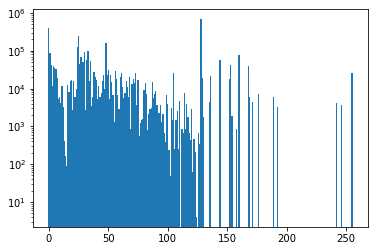

In [233]:
p, count = np.unique(prog, return_counts=True)
plt.bar(p, count, width=1)
# plt.xscale('log')
plt.yscale('log')

In [254]:
def process(file):
    mid = PrettyMIDI(file)
    for inst in mid.instruments:
        if inst.is_drum:
            notes = [n.pitch for n in inst.notes]
            drum_data.append((min(notes), max(notes)))

In [255]:
drum_data = []

In [256]:
for _ in range(500):
    try:
        process(str(random.choice(files)))
    except Exception:
        pass


In [258]:
mins, maxs = zip(*drum_data)

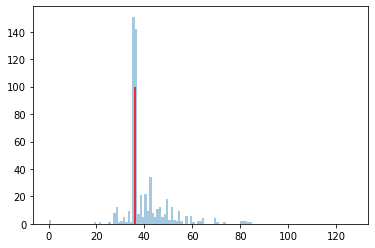

In [266]:
sns.distplot(mins, kde=False, bins=range(128))
plt.vlines([36], 0, 100, color='red')

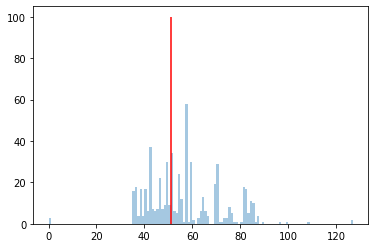

In [267]:
sns.distplot(maxs, kde=False, bins=range(128))
plt.vlines([51], 0, 100, color='red')

In [270]:
np.mean([mi>=36 and ma<=51 for mi, ma in drum_data])

0.3503521126760563

In [271]:
np.mean([mi==36 and ma<=51 for mi, ma in drum_data])

0.07922535211267606

In [272]:
np.mean([mi>=35 and ma<=81 for mi, ma in drum_data])

0.8450704225352113

In [318]:
time_data = []
def process(file):
    mid = PrettyMIDI(file)
    for inst in mid.instruments:
        events = defaultdict(list)
        for n in inst.notes:
            events[n.pitch].extend([n.start, n.end])
        # events = {k:np.array(v) for k,v in events.items()}
        # events = {k:v for k,v in events.items() if (np.diff(times, 1, 0)<0).any()}
        time_data.append({k:np.array(v) for k,v in events.items()})

In [344]:
for _ in range(500):
    try:
        process(str(random.choice(files)))
    except Exception:
        pass


In [345]:
# do notes with the same pitch from the same instrument ever overlap,
# i.e. end of one is after the start of the next?
overlap = [
    (np.diff(times, 1, 0)<0).mean() 
    for tr in time_data for pitch,times in tr.items()]
np.mean(overlap)
# yes for 0.22% of notes

0.0022388024918826937

In [346]:
# what about near-overlap:
overlap = [
    (np.diff(times, 1, 0)<1e-3).mean() 
    for tr in time_data for pitch,times in tr.items()]
np.mean(overlap)
# 1.9% of notes within 1 ms

0.019225615727866633

In [347]:
# what about near-overlap:
overlap = [
    (np.diff(times, 1, 0)<5e-3).mean() 
    for tr in time_data for pitch,times in tr.items()]
np.mean(overlap)
# 2.5% of notes within 5 ms

0.025887205493197684

In [348]:
# is overlap usually less than 1ms?
overlap = [
    (np.diff(times, 1, 0)< -1e-3).mean() 
    for tr in time_data for pitch,times in tr.items()]
np.mean(overlap)
# no

0.002231656901857857

In [349]:
# is overlap usually less than 10ms?
overlap = [
    (np.diff(times, 1, 0)< -10e-3).mean() 
    for tr in time_data for pitch,times in tr.items()]
np.mean(overlap)
# also no

0.0020817257964637513

In [351]:
# is overlap usually less than 1s?
overlap = [
    (np.diff(times, 1, 0)< -1000e-3).mean() 
    for tr in time_data for pitch,times in tr.items()]
np.mean(overlap)
# yes but still ~1/10 of overlaps are greater

0.0002847270539042344

In [27]:
try:
    mid = mido.MidiFile(random.choice(files))
except Exception as e:
    print(e, e.msg)
tempos = {m.tempo for tr in mid.tracks for m in tr if m.type=='set_tempo'}
print('seconds per tick', tuple(tempos)[0] / mid.ticks_per_beat / 1e6)
len(mid.tracks), [(i,m) for i,tr in enumerate(mid.tracks) for m in tr if m.type=='program_change']

seconds per tick 0.0029761927083333333


(17,
 [(1, Message('program_change', channel=0, program=0, time=0)),
  (1, Message('program_change', channel=0, program=100, time=0)),
  (2, Message('program_change', channel=1, program=0, time=0)),
  (2, Message('program_change', channel=1, program=33, time=0)),
  (3, Message('program_change', channel=2, program=0, time=0)),
  (3, Message('program_change', channel=2, program=89, time=0)),
  (4, Message('program_change', channel=3, program=0, time=0)),
  (4, Message('program_change', channel=3, program=82, time=0)),
  (4, Message('program_change', channel=3, program=23, time=0)),
  (4, Message('program_change', channel=3, program=48, time=0)),
  (4, Message('program_change', channel=3, program=103, time=0)),
  (4, Message('program_change', channel=3, program=82, time=0)),
  (4, Message('program_change', channel=3, program=48, time=0)),
  (5, Message('program_change', channel=4, program=0, time=0)),
  (5, Message('program_change', channel=4, program=25, time=0)),
  (5, Message('program_

In [279]:
x = torch.randn(8)
y = torch.ones_like(x, dtype=torch.bool)
y[-3:] = False 
y
x.masked_select(y)

tensor([-0.0388,  0.2996, -1.5249,  0.6905, -0.3885])

In [58]:
from collections import defaultdict
for _ in range(1):
    try:
        mid = mido.MidiFile(random.choice(files))
        print(mid.type)
        pcs = []
        for tr in mid.tracks:
            if not any(m.type=='note_on' for m in tr):
                print(tr)
                continue
            pcs.append(defaultdict(list))
            for m in tr:
                if m.type=='program_change':
                    pcs[-1]['program'].append(m.program)
        print(pcs)
    except Exception as e:
        print(e, e.msg)

1
MidiTrack([
  MetaMessage('smpte_offset', frame_rate=25, hours=32, minutes=0, seconds=0, frames=0, sub_frames=0, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('key_signature', key='A', time=0),
  MetaMessage('set_tempo', tempo=652176, time=0),
  MetaMessage('set_tempo', tempo=652233, time=0),
  MetaMessage('set_tempo', tempo=652176, time=0),
  MetaMessage('set_tempo', tempo=652233, time=0),
  MetaMessage('set_tempo', tempo=652176, time=32767),
  MetaMessage('set_tempo', tempo=652233, time=0),
  MetaMessage('set_tempo', tempo=652233, time=1),
  MetaMessage('end_of_track', time=28904)])
[defaultdict(<class 'list'>, {'program': [0]})]


In [4]:
data_dir = Path('/Users/victor/data/lmd_prep')

In [5]:
batch_size = 32
batch_len = 64

ds = MIDIDataset(data_dir, batch_len)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=0)

In [6]:
%%time
batch = next(iter(dl))
batch['pitch'].shape, batch['time'].shape

CPU times: user 34.4 ms, sys: 23 ms, total: 57.5 ms
Wall time: 87.6 ms


(torch.Size([32, 64]), torch.Size([32, 64]))

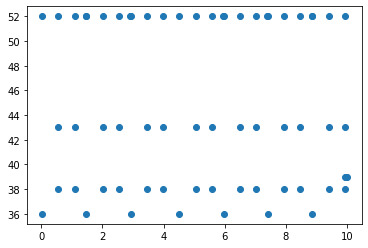

In [7]:
i = 0
plt.scatter(batch['time'][i].cumsum(0), batch['pitch'][i])

# distribution of time delays

In [8]:
times = []
for item in tqdm(it.islice(ds, 10000)):
    times.extend(item['time'])

10000it [00:22, 447.35it/s]


/Users/victor/anaconda3/envs/event-predictor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


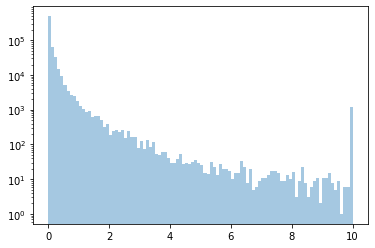

In [9]:
sns.distplot(x=np.clip(np.array(times), 0, 10), kde=False, bins=100)
np.mean(np.array(times)==0)
plt.yscale('log')

## test model time distribution

torch.Size([1000])
tensor(0.9996)


/Users/victor/anaconda3/envs/event-predictor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


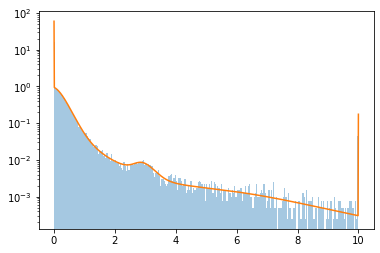

In [2]:
n = 32
r = 0.01
lo, hi = 0, 10

bins = int((hi-lo)/r)

dist = CensoredMixtureLogistic(n, r, lo, hi)

with torch.no_grad():
    h = torch.randn_like(dist.bias)[None]*4
    x = torch.linspace(lo,hi,bins)
    samps = dist.sample(h, 100_000)
    probs = dist(h, x)['log_prob'].exp()

print(probs.shape)
print(probs.sum(0))

sns.distplot(samps, kde=False, norm_hist=True, bins=bins//4)
plt.plot(x, probs/r)
plt.yscale('log')


In [3]:
grads = []
h2 = (h).clone().requires_grad_(True)
x = torch.linspace(lo-1,hi+1,bins*4)
for t in tqdm(x):
    h2.grad = None
    dist(h2, t[None,None])['log_prob'].backward()
    grads.append(h2.grad.detach().clone())
grads = torch.stack(grads, -1)[0]

100%|██████████| 4000/4000 [00:06<00:00, 629.10it/s]


tensor(True)

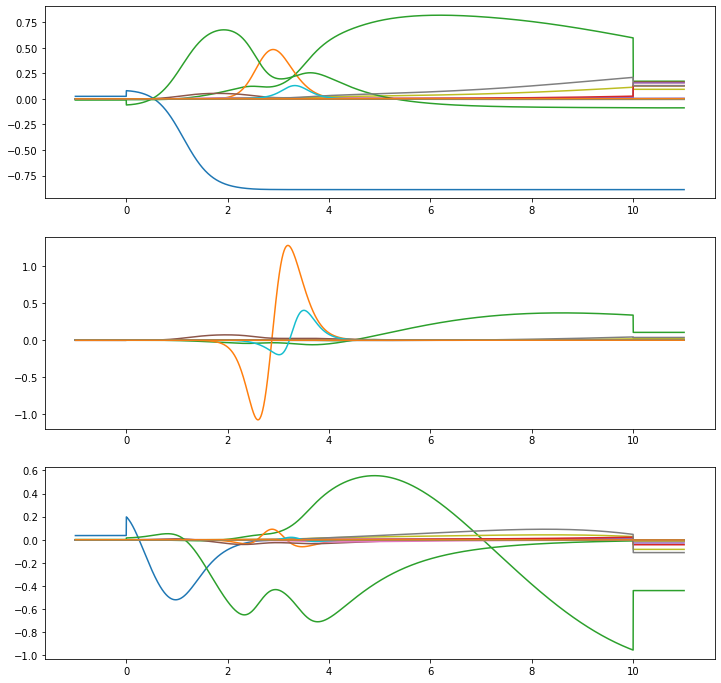

In [4]:
fig, ax = plt.subplots(3,1,figsize=(12,12))
gs = grads.chunk(3, 0)
for a, g in zip(ax, gs):
    a.plot(x, g.t())
g.isfinite().all()

In [11]:
g[~g.isfinite()]

tensor([])

# create model

In [14]:
net = NotePredictor(hidden_size=128, num_pitches=128, num_layers=2)
# net = PitchPredictor.from_checkpoint('/Users/victor/Downloads/0132.ckpt')

In [15]:
net.reset()

In [16]:
%%timeit
net.predict(60, 0)

1.36 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
losses = []

# train

512it [01:19,  6.42it/s]


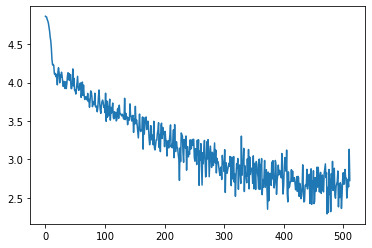

In [18]:
# %%prun

for batch in tqdm(it.islice(dl,512)):
    # batch = torch.LongTensor([notes for notes in it.islice(gen_tracks(batch_len), batch_size)])
    opt.zero_grad()
    r = net(batch['pitch'], batch['time'])
    nll = (-r['pitch_log_probs']).mean()
    nll.backward()
    opt.step()
    losses.append(nll.item())
plt.plot(losses)

In [19]:
# torch.save(net.state_dict(), 'notes_lakh_16k.pt')

In [23]:
%%time
acc = 0
m = 64
ds_it = iter(ds)
for _ in range(m):
    item = next(ds_it)
    pitch, time = item['pitch'], item['time']
    n = len(pitch)-1
    net.reset()
    for i in range(n):
        pred = net.predict(pitch[i], time[i])
        acc += (pred['pitch']==pitch[i+1])/n
acc/m

CPU times: user 4.46 s, sys: 173 ms, total: 4.63 s
Wall time: 4.75 s


tensor(0.1411)

In [38]:
1e3 * 1.08**-128

0.05269377317740327

In [24]:
net.reset(start=False)
note = {'pitch':net.start_token, 'time':0.}
for _ in range(32):
    note = net.predict(**note)
    print(note)

{'pitch': 65, 'time': 7.69986629486084}
{'pitch': 66, 'time': 9.01340389251709}
{'pitch': 70, 'time': 0.0}
{'pitch': 72, 'time': 0.0}
{'pitch': 69, 'time': 5.589588165283203}
{'pitch': 70, 'time': 1.2067210674285889}
{'pitch': 58, 'time': 8.282750129699707}
{'pitch': 70, 'time': 0.0}
{'pitch': 67, 'time': 0.14236612617969513}
{'pitch': 65, 'time': 0.0}
{'pitch': 62, 'time': 0.0}
{'pitch': 77, 'time': 0.0}
{'pitch': 72, 'time': 1.5630669593811035}
{'pitch': 69, 'time': 0.0}
{'pitch': 72, 'time': 0.0}
{'pitch': 76, 'time': 0.0}
{'pitch': 43, 'time': 3.0654561519622803}
{'pitch': 64, 'time': 0.0}
{'pitch': 43, 'time': 0.0}
{'pitch': 78, 'time': 0.0}
{'pitch': 78, 'time': 0.0}
{'pitch': 67, 'time': 0.0}
{'pitch': 37, 'time': 3.123849868774414}
{'pitch': 69, 'time': 0.7305306196212769}
{'pitch': 67, 'time': 0.0}
{'pitch': 84, 'time': 8.417304039001465}
{'pitch': 65, 'time': 8.312026977539062}
{'pitch': 79, 'time': 10.0}
{'pitch': 70, 'time': 0.0}
{'pitch': 53, 'time': 0.5576184988021851}
{'

In [21]:
batch_size*len(losses) / len(ds.files)

0.13836201800462783

# unigram baseline

first, visualize the model's unigram probabilities:


In [ ]:
# TODO: this more more complicated with the pitch_time model

In [24]:
# net_probs = []
# for a in range(130):
#     net.reset()
#     b = net.predict(a, sample=False)
#     net_probs.append(b)
# net_probs = torch.stack(net_probs, 0)

In [25]:
# plt.imshow(net_probs.data.log(), origin='lower', interpolation='nearest')
# plt.ylabel('a')
# plt.xlabel('b')
# plt.title('log P(b|a)')

compute unigram proabilities over the data:

In [24]:
counts = torch.zeros(130,130).long()
for item in tqdm(ds):
    s = item['pitch']
    counts[s[:-1], s[1:]] += 1

100%|██████████| 118414/118414 [03:01<00:00, 652.77it/s]


Text(0.5, 1.0, 'log P(b|a)')

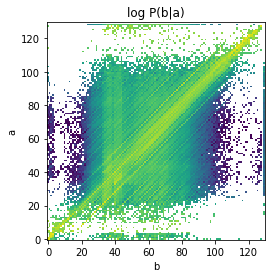

In [43]:
#P(b|a)
probs = counts / counts.sum(1,keepdims=True)
probs
plt.imshow(probs.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(b|a)')

<BarContainer object of 128 artists>

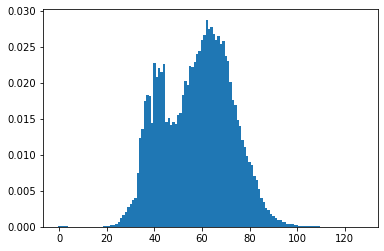

In [51]:
#ignoring start/stop tokens
marg = counts[:128].sum(1) / counts[:128].sum()
plt.bar(range(128), marg, width=1)

In [52]:
# baseline accuracy
(probs[:128, :128].max(1).values * marg).sum()

tensor(0.0723)

<BarContainer object of 130 artists>

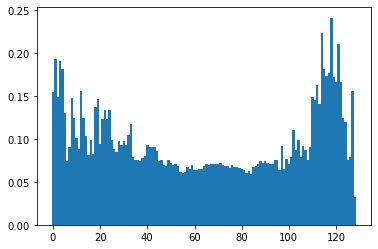

In [28]:
plt.bar(range(130), probs.max(1).values, width=1)

### bigrams

In [62]:
counts = torch.zeros(130,130,130).long()
for item in tqdm(ds):
    s = item['pitch']
    counts[s[:-2], s[1:-1], s[2:]] += 1

100%|██████████| 118414/118414 [03:03<00:00, 645.41it/s]


Text(0.5, 1.0, 'log P(c|a=60,b)')

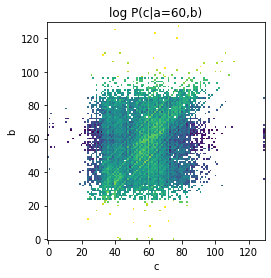

In [64]:
#P(c|a,b)
probs = counts / counts.sum(-1,keepdims=True)
plt.imshow(probs[60].log(), origin='lower', interpolation='nearest')
plt.ylabel('b')
plt.xlabel('c')
plt.title('log P(c|a=60,b)')

Text(0.5, 1.0, 'log P(a,b)')

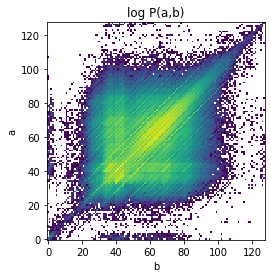

In [65]:
#ignoring start/stop tokens
marg = counts[:128, :128].sum(-1) / counts[:128, :128].sum()
plt.imshow(marg.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(a,b)')

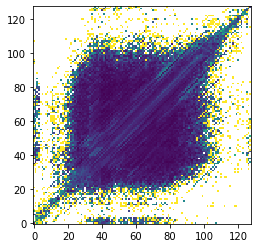

In [71]:
plt.imshow(probs[:128, :128].max(-1).values, origin='lower', interpolation='nearest')

In [74]:
# baseline accuracy
(probs[:128, :128].max(-1).values.nan_to_num(0) * marg).sum()

tensor(0.1371)